In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [37]:
df = pd.read_csv("data_clean_features.csv")
cols = df.columns.tolist()
# let us remove some columns that we do not need NON NUMERIC
DROP_COLS = [
    "blob_url",
    "RowKey",
    "PartitionKey",
    "name",
    "serialization_method",
    "qpy_serialization_success",
    "gate_counts",
    "automatic_method"
]
FEATURES = df.drop(columns=DROP_COLS).columns.tolist()
print(len(df))

186407


C:\Users\aadik\AppData\Local\Temp\ipykernel_7096\3914715196.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data_clean_features.csv")


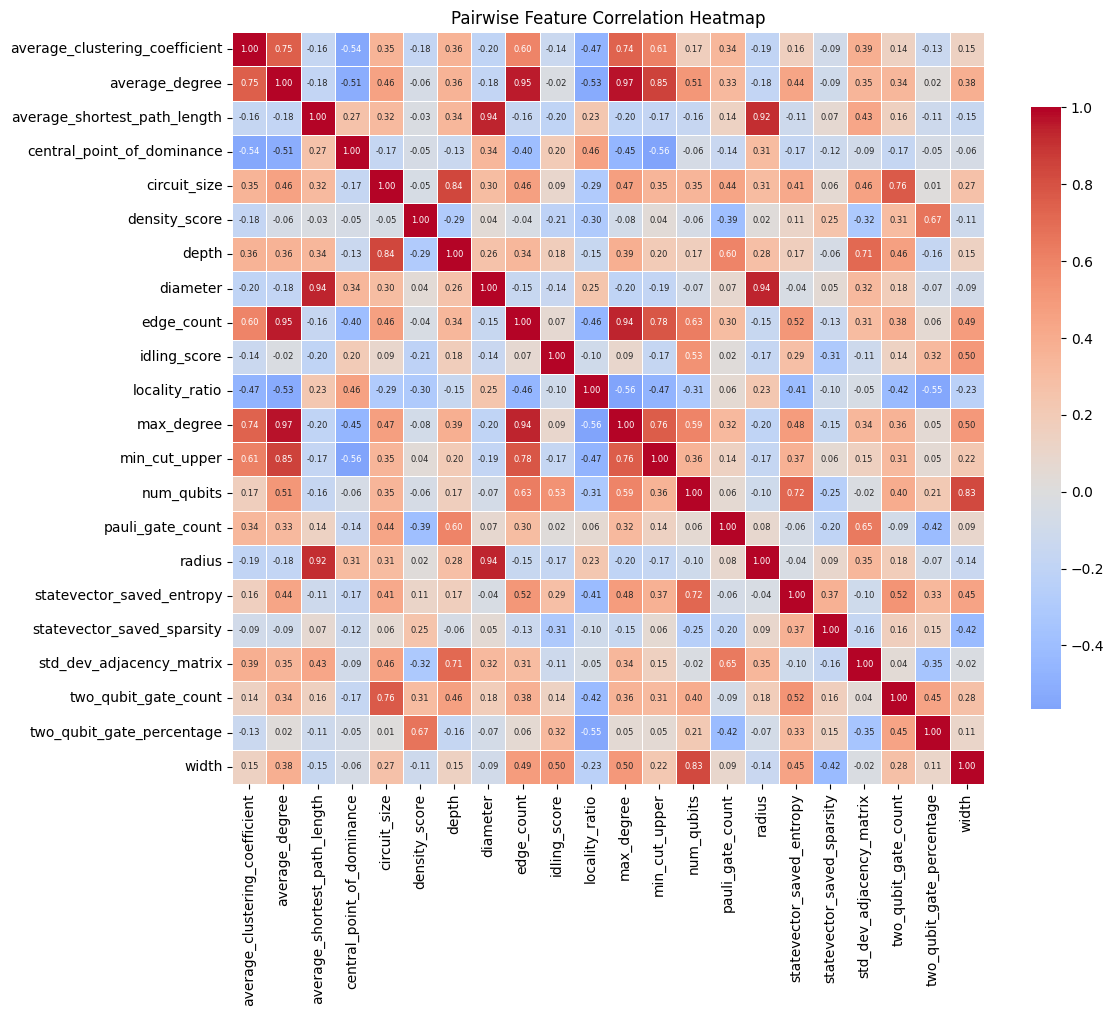

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
df_num = df.select_dtypes(include="number")

# Compute correlation matrix
corr = df_num.corr(method="pearson")

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True,          # <-- show values
    fmt=".2f",           # 2 decimal places
    annot_kws={"size": 6}  # small text
)

plt.title("Pairwise Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [39]:
# Let us train a regression model to estimate sparsity and entropy.
from sklearn.model_selection import train_test_split

TARGET_SPARSITY = "statevector_saved_sparsity"
TARGET_ENTROPY = "statevector_saved_entropy"
FEATURES_CLEAN = [
    f for f in FEATURES
    if f not in [TARGET_ENTROPY, TARGET_SPARSITY]
]
X = df[FEATURES_CLEAN]
y_sparsity = df[TARGET_SPARSITY]
y_entropy = df[TARGET_ENTROPY]

X_train, X_test, y_s_train, y_s_test, y_e_train, y_e_test = train_test_split(
    X, y_sparsity, y_entropy,
    test_size=0.2,
    random_state=42
)
print(len(X), len(X_train), len(X_test))
print(X_train.columns.tolist())

186407 149125 37282
['average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'central_point_of_dominance', 'circuit_size', 'density_score', 'depth', 'diameter', 'edge_count', 'idling_score', 'locality_ratio', 'max_degree', 'min_cut_upper', 'num_qubits', 'pauli_gate_count', 'radius', 'std_dev_adjacency_matrix', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'width']


In [40]:
from sklearn.ensemble import RandomForestRegressor

sparsity_model = RandomForestRegressor(
    n_estimators=100,      # ↓ from 300
    max_depth=15,          # LIMIT depth
    min_samples_leaf=5,    # prevent overfitting
    random_state=42,
    n_jobs=-1
)

entropy_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

sparsity_model.fit(X_train, y_s_train)
entropy_model.fit(X_train, y_e_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [41]:
# from sklearn.linear_model import LinearRegression

# sparsity_model = LinearRegression()
# entropy_model = LinearRegression()

# sparsity_model.fit(X_train, y_s_train)
# entropy_model.fit(X_train, y_e_train)


In [42]:
# from sklearn.linear_model import Ridge

# sparsity_model = Ridge(alpha=1.0)
# entropy_model = Ridge(alpha=1.0)

# sparsity_model.fit(X_train, y_s_train)
# entropy_model.fit(X_train, y_e_train)


In [43]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name}")
    print(f"  R²   : {r2_score(y_test, y_pred):.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print()

evaluate(sparsity_model, X_test, y_s_test, "Sparsity Model")
evaluate(entropy_model, X_test, y_e_test, "Entropy Model")


Sparsity Model
  R²   : 0.7677
  RMSE : 0.1898

Entropy Model
  R²   : 0.8875
  RMSE : 1.9569



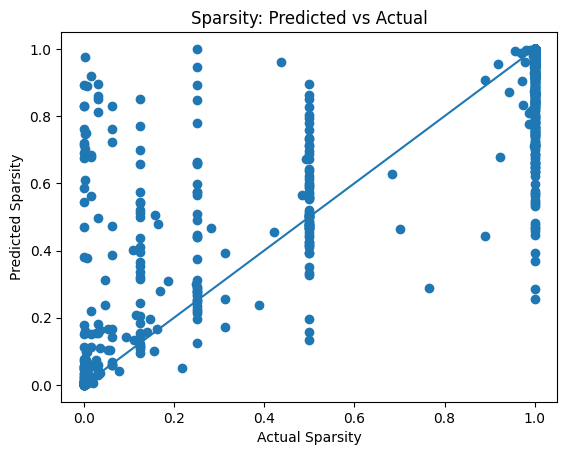

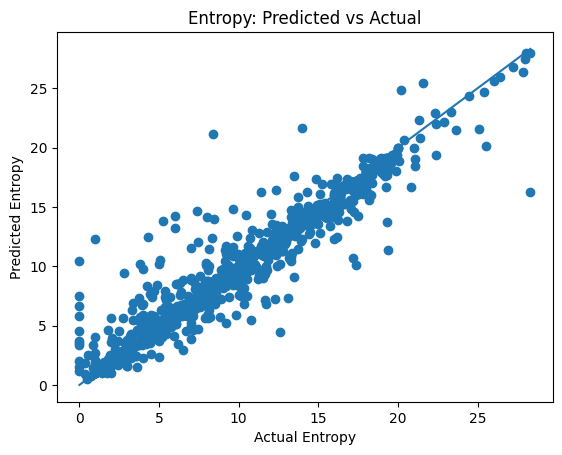

In [44]:
new_X = X_test.iloc[:1000]

sparsity_pred = sparsity_model.predict(new_X)
entropy_pred = entropy_model.predict(new_X)

actual_sparsity = y_s_test.iloc[:1000]
actual_entropy = y_e_test.iloc[:1000]

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(actual_sparsity, sparsity_pred)
plt.plot(
    [actual_sparsity.min(), actual_sparsity.max()],
    [actual_sparsity.min(), actual_sparsity.max()]
)
plt.xlabel("Actual Sparsity")
plt.ylabel("Predicted Sparsity")
plt.title("Sparsity: Predicted vs Actual")
plt.show()

plt.figure()
plt.scatter(actual_entropy, entropy_pred)
plt.plot(
    [actual_entropy.min(), actual_entropy.max()],
    [actual_entropy.min(), actual_entropy.max()]
)
plt.xlabel("Actual Entropy")
plt.ylabel("Predicted Entropy")
plt.title("Entropy: Predicted vs Actual")
plt.show()
